# Framework overview

This notebook provides a basic overview of DISCOVER and its functionality. We will introduce the main features of the framework with a basline dataset and how to discover its symbolic expressions with an fundamental workflow.

There are two executation modes in DISCOVER for dealing with different applications. 
* Mode 1 with SymEqOptimizer

The first mode is designed for discoving PDEs from high-quality data. Partial derivatives are evaluated by numerical differentiation on regular grids. DNN can be optionally utilized to smoothe available data and generate meta data to reduce the impact of noise. The introduction of the whole framework can be found in the first paper [PDF](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013182). GPU is not necessary since the matrix calculation is based on Numpy.

* Mode 2 with Deep_SymEqOptimizer

The second mode originates from a robust verison of DISCOVER, named R_DISCOVER, which is designed to handle sparse and noisy data.  A NN is utilized to fit the system response and evaluate the reward by automatic differentiation. It is trained in a PINN manner when effective physical information are discovered. This mode is more suitable for the high-noisy scenarios. The introduction of the whole framework can be found in the second paper [PDF](https://arxiv.org/ftp/arxiv/papers/2309/2309.07672.pdf). GPU resources are required to acclerate the searching process.


In [1]:

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='numpy.*')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow.*')

from kd.model import KD_DSCV

### 1.Load data and build model

In [2]:
# define optimizer
model = KD_DSCV(
    n_samples_per_batch = 500, # Number of generated traversals by agent per batch
    binary_operators = ['add',"mul", "diff","diff2"],
    unary_operators = ['n2'],
)

In [3]:
# load default dataset, such as Burgers with gridded data
model.import_inner_data(dataset='Burgers', data_type='regular')


-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 3.
                  Sequences have maximum length 64.
RepeatConstraint: [add] cannot occur more than 5 times.
TrigConstraint: [diff, diff2] cannot be a descendant of [diff, diff2].
SoftLengthPrior: No description available.
DiffConstraint_left: [x1] cannot be the left child of [diff, diff2].
DiffConstraint_right: [n2, add, mul, diff, diff2, u1] cannot be the right child of [diff, diff2].
DiffConstraint_des: [add] cannot be a descendant of [diff, diff2].
-- BUILDING PRIOR END ---------------



In [4]:
# print basic information of model and dataset
model.info()

Library:  x1,u1,add,mul,diff,diff2,n2


In [5]:
# suport user-defined dataset
import scipy.io as scio
import numpy as np
data_path = './kd/data_file/burgers.mat'
def load_data(path):
    data = scio.loadmat(path)
    u=data.get("usol")  # (x_shape, t_shape)
    x=np.squeeze(data.get("x")).reshape(-1,1)
    t=np.squeeze(data.get("t").reshape(-1,1))
    return u,x,t
u,x,t = load_data(data_path)
model.make_outter_data(u,x,t,data_type='regular')

### 2. Model training

In [6]:
# single-iteration training
step_output = model.train_one_step()
print(f"Current best expression is {step_output['expression']} and its reward is {step_output['r']}")

Training epoch 1/100, current best R: 0.5679, cost time: 4.87

	** New best
	Reward: 0.5679006611561859
	MSE:0.003770687129671451
	Traversal: mul,n2,x1,diff,n2,n2,u1,x1
	Expression:
-0.0244 * mul(n2(x1),diff(n2(n2(u1)),x1))
Current best expression is -0.0244 * mul(n2(x1),diff(n2(n2(u1)),x1)) and its reward is 0.5679006611561859


In [7]:
# training with defined iterations
# support continual training with model.train()
output = model.train(n_epochs=50)
print(f"Best expression is {output['expression']} and its reward is {output['r']}")

Progress:   2%|█                                                     | 1/50 [00:00<00:41,  1.19it/s]

Training epoch 2/100, current best R: 0.5966, cost time: 0.84

	** New best
	Reward: 0.5965950680870147
	MSE:0.0028189798784921
	Traversal: add,diff,n2,n2,u1,x1,diff2,u1,x1
	Expression:
-0.3136 * diff(n2(n2(u1)),x1) + 0.0393 * diff2(u1,x1)


Progress:   8%|████▎                                                 | 4/50 [00:03<00:44,  1.03it/s]

Training epoch 5/100, current best R: 0.9520, cost time: 0.93

	** New best
	Reward: 0.951975704788587
	MSE:5.914983969248236e-06
	Traversal: add,diff,n2,u1,x1,diff2,u1,x1
	Expression:
-0.5002 * diff(n2(u1),x1) + 0.0984 * diff2(u1,x1)


Progress:  18%|█████████▋                                            | 9/50 [00:07<00:31,  1.30it/s]

Training epoch 10/100, current best R: 0.9520, cost time: 0.69


Progress:  38%|████████████████████▏                                | 19/50 [00:15<00:23,  1.33it/s]

Training epoch 20/100, current best R: 0.9520, cost time: 0.74


Progress:  58%|██████████████████████████████▋                      | 29/50 [00:22<00:15,  1.37it/s]

Training epoch 30/100, current best R: 0.9520, cost time: 0.72


Progress:  78%|█████████████████████████████████████████▎           | 39/50 [00:30<00:07,  1.40it/s]

Training epoch 40/100, current best R: 0.9520, cost time: 0.69


Progress:  98%|███████████████████████████████████████████████████▉ | 49/50 [00:37<00:00,  1.29it/s]

Training epoch 50/100, current best R: 0.9520, cost time: 0.80


Progress: 100%|█████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]

-- Searching End ------------------
Best expression is -0.5002 * diff(n2(u1),x1) + 0.0984 * diff2(u1,x1) and its reward is 0.951975704788587


### 3. Ouput the expression in priorit queue (default: Top 10)

In [8]:
model.print_pq()
#mannually select the finally result


Top 0 result:
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Traversal: add,diff2,u1,x1,diff,n2,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)

Top 1 result:
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Traversal: add,diff2,u1,x1,diff,mul,u1,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(mul(u1,u1),x1)

Top 2 result:
	Reward: 0.951975704788587
	MSE:5.914983969248236e-06
	Traversal: add,diff,n2,u1,x1,diff2,u1,x1
	Expression:
-0.5002 * diff(n2(u1),x1) + 0.0984 * diff2(u1,x1)

Top 3 result:
	Reward: 0.9427449589571768
	MSE:5.704809497430445e-06
	Traversal: add,u1,add,diff2,u1,x1,diff,mul,u1,u1,x1
	Expression:
-0.0009 * u1 + 0.0981 * diff2(u1,x1) + -0.4989 * diff(mul(u1,u1),x1)

Top 4 result:
	Reward: 0.6274323224742858
	MSE:0.0022791887734717954
	Traversal: mul,diff,n2,x1,x1,diff,mul,u1,mul,u1,u1,x1
	Expression:
0.0638 * mul(diff(n2(x1),x1),diff(mul(u1,mul(u1,u1)),x1))

Top 5 result:
	Reward: 0.6274323224742858
	MSE:0.0022791887734717954

### 4. Visulization of results

In [ ]:
# plot the tree structure of the best expression
graph = model.plot(fig_type ='tree')
graph

2024-10-17 20:54:33,202-matplotlib.font_manager-WARNING-findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2024-10-17 20:54:33,212-matplotlib.font_manager-WARNING-findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


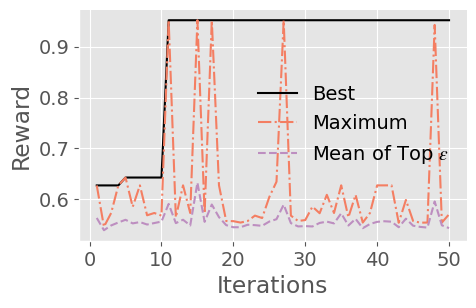

In [ ]:
# Plot the evolution process
model.plot(fig_type='evolution')

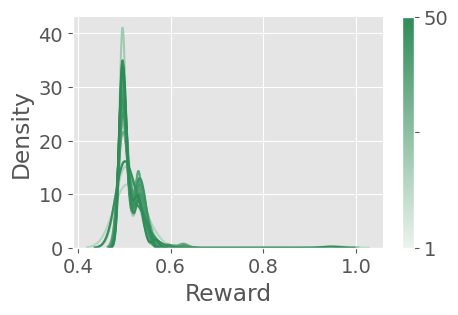

In [ ]:
# Plot the density distribution
model.plot(fig_type='density')

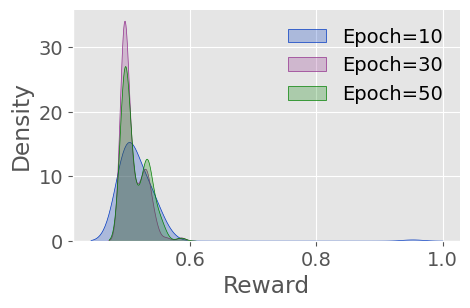

In [ ]:
epoches = [10,30,50] # plot the reward distribution of given epoches
model.plot(fig_type='density',epoches=epoches)

# Mode 2 Deep_SymEqOptimizer

### 1.Load data and build model

In [1]:
import warnings
import os
import numpy as np
import scipy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='numpy.*')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow.*')

from kd.model import KD_DSCV_Pinn


In [2]:
# define optimizer
model = KD_DSCV_Pinn(
    n_samples_per_batch = 1000, # Number of generated traversals by agent per batch
    binary_operators = ["add_t", "mul_t", "div_t", "diff_t","diff2_t",],
    unary_operators = ['n2_t'],
)



In [3]:
# import outside dataset
np.random.seed(42)
def prepare_data():
    
    data = scipy.io.loadmat('./kd/data_file/burgers2.mat')
    t = np.real(data['t'].flatten()[:,None])
    x = np.real(data['x'].flatten()[:,None])
    Exact = np.real(data['usol']).T  # t first
    X, T = np.meshgrid(x,t)

    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0) 

    x_len = len(x)
    total_num = X_star.shape[0]
    sample_num = int(total_num*0.1)
    print(f"random sample number: {sample_num} ")
    ID = np.random.choice(total_num, sample_num, replace = False)
    X_u_meas = X_star[ID,:]
    u_meas = u_star[ID,:]  
    return X_u_meas,u_meas, lb,ub

x,y,lb,ub = prepare_data()

random sample number: 2585 


## 2. Model train

In [4]:
step_output = model.fit(x,y,[lb,ub],n_epochs=20)


2024-11-23 20:42:04,097-root-INFO-ANN(
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (mid_linear): ModuleList(
    (0-6): 7 x Linear(in_features=20, out_features=20, bias=True)
  )
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
2024-11-23 20:42:04,099-root-INFO-Total params are 3021


-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 3.
                  Sequences have maximum length 64.
RepeatConstraint: [add_t] cannot occur more than 5 times.
TrigConstraint: [diff_t, diff2_t] cannot be a descendant of [diff_t, diff2_t].
SoftLengthPrior: No description available.
DiffConstraint_left: [x1] cannot be the left child of [diff_t, diff2_t].
DiffConstraint_right: [n2_t, add_t, mul_t, div_t, diff_t, diff2_t, u1] cannot be the right child of [diff_t, diff2_t].
DiffConstraint_des: [add_t] cannot be a descendant of [diff_t, diff2_t].
-- BUILDING PRIOR END ---------------

Using device: cpu
NN evaluator training with data


2024-11-23 20:42:09,744-root-INFO-epoch: 500, loss_u: 9.946439968189225e-05 , loss_val:0.00011534936493262649
2024-11-23 20:42:15,812-root-INFO-epoch: 1000, loss_u: 1.8434046069160104e-05 , loss_val:2.6788489776663482e-05
2024-11-23 20:42:20,988-root-INFO-epoch: 1500, loss_u: 9.229307579516899e-06 , loss_val:1.5635532690794207e-05
2024-11-23 20:42:26,808-root-INFO-epoch: 2000, loss_u: 5.21548872711719e-06 , loss_val:1.052089919539867e-05
2024-11-23 20:42:31,653-root-INFO-epoch: 2500, loss_u: 3.3915493986569345e-06 , loss_val:7.776778147672303e-06
2024-11-23 20:42:37,243-root-INFO-epoch: 3000, loss_u: 2.3230561509990366e-06 , loss_val:5.764582056144718e-06
2024-11-23 20:42:41,531-root-INFO-epoch: 3500, loss_u: 1.6956282706814818e-06 , loss_val:4.433052708918694e-06
2024-11-23 20:42:46,004-root-INFO-epoch: 4000, loss_u: 1.2765499377564993e-06 , loss_val:3.4255360787938116e-06
2024-11-23 20:42:51,581-root-INFO-epoch: 4500, loss_u: 1.9869912648573518e-06 , loss_val:4.026646365673514e-06
20

generating metadata
The No.0 pde discovery process


Progress:   5%|██▋                                                   | 1/20 [00:17<05:24, 17.07s/it]

Training epoch 2/20, current best R: 0.7427, cost time: 16.98

	** New best
	Reward: 0.7427424424905452
	MSE:0.00034209436853416264
	Traversal: add_t,add_t,diff_t,n2_t,u1,x1,add_t,diff_t,u1,x1,mul_t,diff2_t,mul_t,u1,mul_t,u1,u1,x1,u1,u1
	Expression:
-0.2494 * diff_t(n2_t(u1),x1) + -0.1820 * diff_t(u1,x1) + 0.0476 * mul_t(diff2_t(mul_t(u1,mul_t(u1,u1)),x1),u1) + -0.0384 * u1


Progress:  20%|██████████▊                                           | 4/20 [00:51<03:18, 12.41s/it]

Training epoch 5/20, current best R: 0.9634, cost time: 12.38

	** New best
	Reward: 0.9633658455291237
	MSE:1.1920421911781887e-06
	Traversal: add_t,diff2_t,u1,x1,diff_t,n2_t,u1,x1
	Expression:
0.1000 * diff2_t(u1,x1) + -0.4998 * diff_t(n2_t(u1),x1)


Progress:  45%|████████████████████████▎                             | 9/20 [01:43<01:54, 10.39s/it]

Training epoch 10/20, current best R: 0.9634, cost time: 9.03


Progress:  70%|█████████████████████████████████████                | 14/20 [02:40<01:08, 11.39s/it]

In [ ]:
print(f"Current best expression is {step_output['expression']} and its reward is {step_output['r']}")